## Checking the backward phase

In [1]:
import numpy as np
import sempler
import sempler.generators
import sempler.utils
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

import causalicp as icp
from causalicp.test.test_vs_r import process_accepted_sets, process_confints, process_pvalues

[{1: (2.0751664848086753, 1.1816550366394711)}, {1: (2.415080254792156, 1.9902253081352055)}, {0: (2.996703016941562, 1.577212524240688)}]


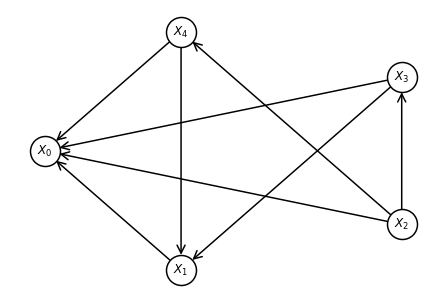

In [8]:
i = 4
path = 'causalicp/test/test_cases/case_%d' % i
XX = np.load(path + '.npy')
with open(path + '.pickle', 'rb') as f:
    (scm, interventions, data) = pickle.load(f)
assert (data == XX).all()
print(interventions)
sempler.utils.plot_graph(scm.W)

In [9]:
# Load R's accepted sets
path = 'causalicp/test/test_cases/icp_result_%d_accepted.csv' % i
df = pd.read_csv(path)
print(df)
true_accepted_sets = process_accepted_sets(df)
true_accepted_sets

Empty DataFrame
Columns: [Unnamed: 0, V1, V2, V3, V4]
Index: []


set()

In [12]:
# Load R's confidence intervals
path = 'causalicp/test/test_cases/icp_result_%d_confints.csv' % i
df = pd.read_csv(path)
print(df)
true_confints = process_confints(df)
true_confints

Empty DataFrame
Columns: [Unnamed: 0]
Index: []


In [5]:
# Load R's p-values
path = 'causalicp/test/test_cases/icp_result_%d_pvals.csv' % i
df = pd.read_csv(path)
print(df)
true_pvalues = process_pvalues(df)
true_pvalues

   Unnamed: 0  x
0           1  1
1           2  1
2           3  1
3           4  1


{0: nan, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

### Test ICP

In [6]:
%%time
target = 0
result = icp.fit(XX, target, alpha=0.001, sets=None, verbose=True)

Tested sets and their p-values:
  set() rejected : 8.374764447568074e-27
  {1} rejected : 9.90080444989669e-209
  {2} rejected : 6.449214859816725e-32
  {3} rejected : 8.973444565375945e-40
  {4} rejected : 8.095092964646903e-27
  {1, 2} rejected : 3.987422025411602e-226
  {1, 3} rejected : 1.6283226990277594e-202
  {1, 4} rejected : 7.952544513280672e-209
  {2, 3} rejected : 9.263462101495931e-40
  {2, 4} rejected : 1.113181037959808e-38
  {3, 4} rejected : 4.0526494993070837e-48
  {1, 2, 3} rejected : 3.0213667763603734e-206
  {1, 2, 4} rejected : 4.226892028999093e-213
  {1, 3, 4} rejected : 1.5843678346411403e-181
  {2, 3, 4} rejected : 7.729071334735338e-51
  {1, 2, 3, 4} rejected : 4.726979746191114e-191
Estimated parental set: None



ValueError: zero-size array to reduction operation minimum which has no identity

In [7]:
result.pvalues

NameError: name 'result' is not defined

In [ ]:
0.01841834 / 0.02449

In [ ]:
0.00819642 / 0.01082

In [ ]:
accepted_sets = set(tuple(s) for s in result.accepted)
accepted_sets == true_accepted_sets

In [ ]:
accepted_sets - true_accepted_sets

In [ ]:
true_accepted_sets - accepted_sets

In [ ]:
result.conf_intervals

In [ ]:
true_pvalues

In [ ]:
result.pvalues

In [ ]:
np.all([np.isclose(p1, p2, equal_nan=True) for (p1, p2) in zip(true_pvalues.values(), result.pvalues.values())])

In [ ]:
true_confints

In [ ]:
result.conf_intervals

In [ ]:
scm.W

In [ ]:
result.set_coefficients[(2,4,)]

### Test the GaussianData class

In [ ]:
raise Exception("Halt")

In [ ]:
from causalicp import GaussianData

In [ ]:
data = GaussianData(XX)
scm.W, scm.means

#### Not the same to center data and to add intercept column

In [ ]:
y = 2
S = {1,4}

In [ ]:
data = GaussianData(XX, method = 'raw')

In [ ]:
%%time
data.regress_pooled(y, S)

In [ ]:
data = GaussianData(XX, method = 'scatter')

In [ ]:
%%time
data.regress_pooled(y, S)

In [ ]:
0.00016855535884509765 * 4

# 